In [71]:
import pandas as pd
import numpy as np
from typing import Sequence
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score

# Data Loading, Label Encoding

In [72]:
train = pd.read_csv('data/processed/cases_train.csv', parse_dates=['date_confirmation'])
train['date_confirmation'] = train['date_confirmation'].apply(lambda r: r.value)
# 0 hospitalized
# 1 nonhospitalized
# 6 deceased

In [73]:
le = LabelEncoder()
for col in train.columns:
    if train[col].dtype == 'object' and col != 'outcome_group':
        train[col] = le.fit_transform(train[col])

train['outcome_group'] = pd.Categorical(train['outcome_group']).codes
X = train.iloc[:, 0:-1]
y = train.iloc[:, -1]

In [74]:
print(train['outcome_group'].loc[6],train['outcome_group'].loc[0],train['outcome_group'].loc[1])

0 1 2


# Feature Selection

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.8)

In [46]:
cols: Sequence[str] = X_train.columns.to_list()
desired_n_features = round(len(cols)*0.75)
# desired_n_features = 10

while (len(cols) != desired_n_features):
    print('working with {0}/{1} features'.format(len(cols),X_train.shape[1]))
    highest_score = 0
    least_reduction_feature: str
    for f in cols:
        cols_t = [f_ for f_ in cols if f_ != f]
        X_train_fs_no_f = X_train[cols_t]
        X_valid_fs_no_f = X_valid[cols_t]
        pred = KNeighborsClassifier().fit(X_train_fs_no_f,y_train).predict(X_valid_fs_no_f)
        valid_score_no_f = f1_score(y_valid, pred, average='macro')
        if valid_score_no_f > highest_score:
            highest_score = valid_score_no_f
            least_reduction_feature = f
    print('new valid: ',highest_score)
    print('removing feature', least_reduction_feature)
    cols.pop(cols.index(least_reduction_feature))
print('done!')

X_train_kn = X_train[cols]
X_valid_kn = X_valid[cols]

working with 14/14 features
new valid:  0.7409916846263886
removing feature sex
working with 13/14 features
new valid:  0.7417347314269834
removing feature latitude
working with 12/14 features
new valid:  0.7424537054162929
removing feature Confirmed
working with 11/14 features
new valid:  0.7453752163123181
removing feature Recovered
done!


In [76]:
cols: Sequence[str] = X_train.columns.to_list()
desired_n_features = round(len(cols)*0.75)
# desired_n_features = 10

while (len(cols) != desired_n_features):
    print('working with {0}/{1} features'.format(len(cols),X_train.shape[1]))
    highest_score = 0
    least_reduction_feature: str
    for f in cols:
        cols_t = [f_ for f_ in cols if f_ != f]
        X_train_fs_no_f = X_train[cols_t]
        X_valid_fs_no_f = X_valid[cols_t]
        pred = XGBClassifier().fit(X_train_fs_no_f,y_train).predict(X_valid_fs_no_f)
        valid_score_no_f = f1_score(y_valid, pred, average='macro')
        if valid_score_no_f > highest_score:
            highest_score = valid_score_no_f
            least_reduction_feature = f
    print('new valid: ',highest_score)
    print('removing feature', least_reduction_feature)
    cols.pop(cols.index(least_reduction_feature))
print('done!')

X_train_xgb = X_train[cols]
X_valid_xgb = X_valid[cols]

working with 14/14 features
new valid:  0.7901551768846599
removing feature Recovered
working with 13/14 features
new valid:  0.7913145834228031
removing feature sex
working with 12/14 features
new valid:  0.793469011341336
removing feature longitude
working with 11/14 features
new valid:  0.7985674069004115
removing feature province
done!


# Balancing Dataset
### Initialize KFold, 80:20 split, class weights, scoring criteria

In [77]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore') 
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

k_fold = StratifiedKFold(n_splits=10, shuffle=True)

def f1_deceased_func(y_true, y_pred):
    return f1_score(y_true, y_pred, average=None)[0]
f1_deceased = make_scorer(f1_deceased_func)

scoring = {
    'Accuracy': 'accuracy',
    'F1_macro': 'f1_macro',
    'F1_macro_deceased': f1_deceased,
    # 'ROC': 'roc_auc_ovr_weighted'
}

### Scaling and Oversampling

In [78]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

print(Counter(y_train))

std = StandardScaler()
std.fit(X_train_kn)
X_train_kn_scaled = std.transform(X_train_kn)
X_valid_kn_scaled = std.transform(X_valid_kn)

sm = SMOTETomek(sampling_strategy='minority', smote=SMOTE(k_neighbors=50), n_jobs=-1)
X_train_res, y_train_res = sm.fit_resample(X_train_kn_scaled,y_train)

under = ClusterCentroids()
X_train_res, y_train_res = under.fit_resample(X_train_res,y_train_res)

print(Counter(y_train_res))

Counter({1: 10592, 2: 2379, 0: 798})
Counter({0: 8217, 1: 8217, 2: 8217})


### Before SMOTETomek

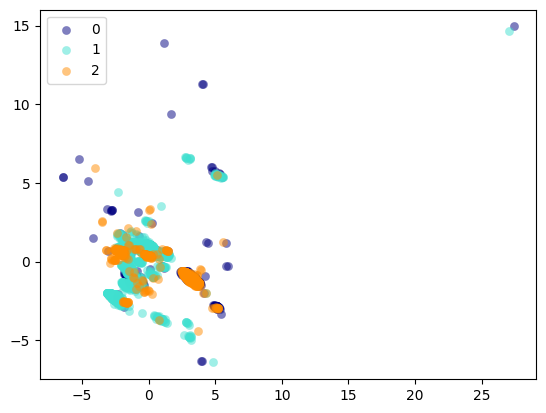

In [59]:
std = StandardScaler()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(std.fit_transform(X_train_kn))
target_names = ['0','1','2']

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_pca[y_train == i, 0], X_pca[y_train == i, 1], color=color, alpha=.5, lw=0.2, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

### After SMOTETomek

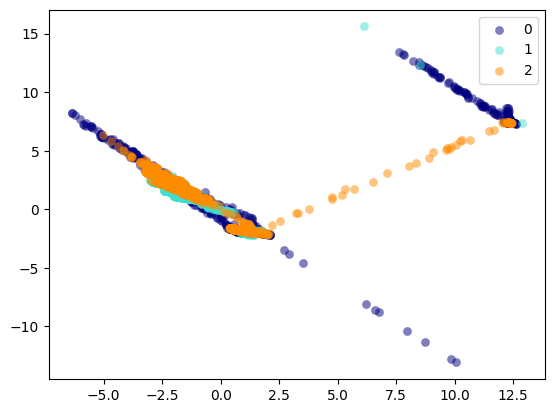

In [60]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_res)
target_names = ['0','1','2']

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_pca[y_train_res == i, 0], X_pca[y_train_res == i, 1], color=color, alpha=.5, lw=0.2, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

# Hyperparameter Tuning

In [79]:
def clf_stats(search, res, X_valid):
    mean_cols = []
    for col in res.columns:
        if ('test' in col) & ('split' in col):
            mean_cols.append(col)

    pred = search.predict(X_valid)
    print('valid F1 macro: ', f1_score(y_valid,pred, average='macro'))
    print('valid deceased: ', f1_score(y_valid,pred, average=None)[0])
    check = pd.DataFrame({'pred': pred, 'actual': y_valid})
    check['correct'] = check['pred'] == check['actual']
    print('valid accuracy: ', len(check[check['correct'] == True])/len(pred))
    print(f'Best Classifier:\n{res[mean_cols].iloc[search.best_index_]}')
    print('minmin: ', pd.DataFrame(search.cv_results_)[mean_cols].min().min())
    print(search.best_params_)
    incorrect = check[check['correct'] == False]
    total = len(incorrect)
    n_0 = len(incorrect[(incorrect['actual'] == 0) | (incorrect['pred'] == 0)]) 
    p0w1 = len(incorrect[(incorrect['actual'] == 1) & (incorrect['pred'] == 0)])
    p0w2 = len(incorrect[(incorrect['actual'] == 2) & (incorrect['pred'] == 0)])
    p1w0 = len(incorrect[(incorrect['actual'] == 0) & (incorrect['pred'] == 1)])
    p1w2 = len(incorrect[(incorrect['actual'] == 2) & (incorrect['pred'] == 1)])
    p2w0 = len(incorrect[(incorrect['actual'] == 0) & (incorrect['pred'] == 2)])
    p2w1 = len(incorrect[(incorrect['actual'] == 1) & (incorrect['pred'] == 2)])
    print(f'total incorrect: {total}/{len(X_valid)}')
    print('predicted 0, was 1:', p0w1)
    print('predicted 0, was 2:', p0w2)
    print('predicted 1, was 0:', p1w0)
    print('predicted 1, was 2:', p1w2)
    print('predicted 2, was 0:', p2w0)
    print('predicted 2, was 1:', p2w1)
    # print(f'total 2-0 confusions: {p0w2+p2w0}/{total}')
    # print(f'total 1-0 confusions: {p0w1+p1w0}/{total}')
    # print(f'total 2-1 confusions: {p1w2+p2w1}/{total}')
    print(f'number of errors involving 0: {n_0}/{total}')

### KNeighbors

In [37]:
kn = KNeighborsClassifier()
params = {
    'n_neighbors': np.arange(100,200,1),
    'weights': ['uniform','distance'],
    'algorithm': ['ball_tree','kd_tree','brute'],
    'leaf_size': np.arange(10,50,1),
    'p': [1,2],
    'metric': ['cityblock','euclidean','l1','l2','manhattan']
}
kn_search = RandomizedSearchCV(kn,
                               params,
                               cv=k_fold,
                               scoring=scoring,
                               refit='F1_macro_deceased',
                               n_iter=50,
                               n_jobs=-1,
                               error_score='raise').fit(X_train_res,y_train_res)

kn_res = pd.DataFrame(kn_search.cv_results_)
kn_res['classifier'] = 'KNeighbors'
clf_stats(kn_search, kn_res, X_valid_kn_scaled)

valid F1 macro:  0.7545319544829171
valid deceased:  0.4540540540540541
valid accuracy:  0.9058960209119954
Best Classifier:
split0_test_Accuracy             0.871252
split1_test_Accuracy             0.864903
split2_test_Accuracy             0.863492
split3_test_Accuracy             0.862787
split4_test_Accuracy             0.873369
split5_test_Accuracy             0.871605
split6_test_Accuracy             0.862787
split7_test_Accuracy             0.875485
split8_test_Accuracy             0.867372
split9_test_Accuracy             0.865256
split0_test_F1_macro             0.869961
split1_test_F1_macro             0.864512
split2_test_F1_macro             0.862595
split3_test_F1_macro             0.861108
split4_test_F1_macro             0.872558
split5_test_F1_macro             0.870427
split6_test_F1_macro             0.861614
split7_test_F1_macro             0.874854
split8_test_F1_macro             0.866602
split9_test_F1_macro             0.864337
split0_test_F1_macro_deceased    0.

### XGBoost
Reference: https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

In [89]:
distr = Counter(y_train)
w0 = len(y_train)/(distr[0]*3)
w1 = len(y_train)/(distr[1]*3)
w2 = len(y_train)/(distr[2]*3)
s0 = 0.08
s1 = 0.12
s2 = 0.12
class_weights_dict = {0: s0*w0, 1: s1*w1, 2: s2*w2}
# class_weights_dict = {0: 1, 1: 1, 2: 1}
class_weights = class_weight.compute_sample_weight(class_weight=class_weights_dict, y=y_train)

xgb = XGBClassifier(objective='multi:softmax', tree_method='exact', num_class=3, eval_metric='mlogloss')
params = {
    'booster' : ['gbtree'],
    'eta': np.linspace(0.01,0.3,20),
    'gamma': np.linspace(0,3,20),
    'max_depth': np.arange(1,20,1),
    'min_child_weight': np.linspace(0,10,20),
    'subsample': [0.5,1],
    'lambda': np.linspace(0,5,20),
    'alpha': np.linspace(0,5,20)
}
xgb_search = RandomizedSearchCV(xgb,
                                params,
                                cv=k_fold,
                                scoring=scoring,
                                refit='Accuracy',
                                n_jobs=None,
                                n_iter=30
                                ).fit(X_train_xgb,y_train,sample_weight=class_weights)
xgb_res = pd.DataFrame(xgb_search.cv_results_)
xgb_res['classifier'] = 'XGBoost'
clf_stats(xgb_search, xgb_res, X_valid_xgb)

valid F1 macro:  0.7880050170062486
valid deceased:  0.5238095238095238
valid accuracy:  0.9343595701423177
Best Classifier:
split0_test_Accuracy             0.920116
split1_test_Accuracy             0.922295
split2_test_Accuracy             0.925200
split3_test_Accuracy             0.934641
split4_test_Accuracy             0.941176
split5_test_Accuracy             0.927378
split6_test_Accuracy             0.928105
split7_test_Accuracy             0.926652
split8_test_Accuracy             0.936819
split9_test_Accuracy             0.934593
split0_test_F1_macro             0.755849
split1_test_F1_macro             0.758630
split2_test_F1_macro             0.774890
split3_test_F1_macro             0.800609
split4_test_F1_macro             0.814679
split5_test_F1_macro             0.781348
split6_test_F1_macro             0.780786
split7_test_F1_macro             0.777359
split8_test_F1_macro             0.782873
split9_test_F1_macro             0.791644
split0_test_F1_macro_deceased    0.

### Compile CV Results

In [95]:
all_res = pd.concat([xgb_res, kn_res])
all_res = all_res[['classifier','params','mean_test_F1_macro','mean_test_F1_macro_deceased','mean_test_Accuracy']]
all_res['params'] = all_res['params'].apply(lambda x: str(x)[1:-1].replace('\'','').replace(': ','=').replace(', ',','))
# all_res.to_csv('res.csv', index=False)
all_res

,classifier,params,mean_test_F1_macro,mean_test_F1_macro_deceased,mean_test_Accuracy
0,XGBoost,"subsample=0.5,min_child_weight=2.1052631578947...",0.778159,0.510604,0.926574
1,XGBoost,"subsample=1,min_child_weight=5.789473684210526...",0.779412,0.520224,0.927156
2,XGBoost,"subsample=1,min_child_weight=5.789473684210526...",0.779849,0.519599,0.927809
3,XGBoost,"subsample=1,min_child_weight=4.736842105263157...",0.776260,0.516011,0.925775
4,XGBoost,"subsample=0.5,min_child_weight=8.9473684210526...",0.766375,0.490471,0.919239
...,...,...,...,...,...
45,KNeighbors,"weights=distance,p=2,n_neighbors=123,metric=l1...",0.865240,0.803097,0.866279
46,KNeighbors,"weights=uniform,p=1,n_neighbors=106,metric=l1,...",0.841341,0.769334,0.842434
47,KNeighbors,"weights=uniform,p=2,n_neighbors=146,metric=man...",0.835653,0.760182,0.837037
48,KNeighbors,"weights=uniform,p=2,n_neighbors=117,metric=cit...",0.839703,0.766044,0.840952


# Overfitting

### KNeigbors

In [ ]:
from sklearn.metrics import accuracy_score

nn = np.arange(1,201,2)
perf_train = []
perf_valid = []

highest_valid = 0
best_pred = None
best_nn = 1
for i in nn:
    kn_of = KNeighborsClassifier(n_neighbors=i, weights='distance', p=2, metric='l1', leaf_size=10, algorithm='ball_tree', n_jobs=-1)
    kn_of.fit(X_train_res,y_train_res)
    pred_train = kn_of.predict(X_train_kn_scaled)
    pred_valid = kn_of.predict(X_valid_kn_scaled)
    f1_train = f1_deceased_func(y_train,pred_train)
    f1_valid = f1_deceased_func(y_valid,pred_valid)
    perf_train.append(f1_train)
    perf_valid.append(f1_valid)
    if f1_valid > highest_valid:
        best_pred = pred_valid
        highest_valid = f1_valid
        best_nn = i
perf_train_np = np.array(perf_train)
perf_valid_np = np.array(perf_valid)

plt.plot(nn, perf_train)
plt.plot(nn, perf_valid)
plt.show()

print(best_nn)
print(highest_valid)
print(f1_score(y_valid, best_pred))
print(accuracy_score(y_valid, best_pred))


### XGBoost

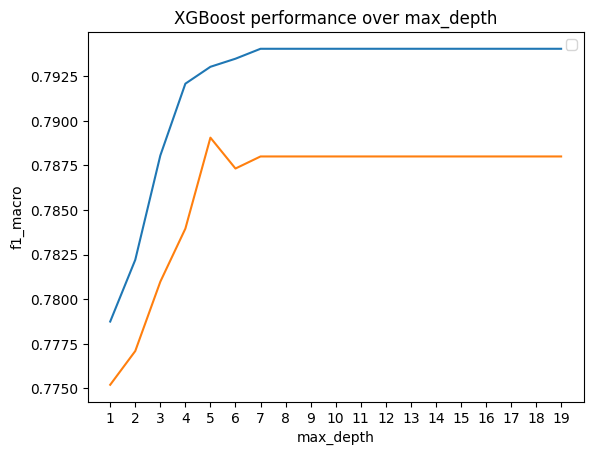

5
0.7890606305311049
[0.52757794 0.9841927  0.85541126]
0.9349404589021203


In [94]:
from sklearn.metrics import accuracy_score

max_depth = np.arange(1,20,1)
perf_train = []
perf_valid = []

w0 = len(y_train)/(distr[0]*3)
w1 = len(y_train)/(distr[1]*3)
w2 = len(y_train)/(distr[2]*3)
s0 = 0.08
s1 = 0.12
s2 = 0.12
class_weights_dict = {0: s0*w0, 1: s1*w1, 2: s2*w2}
class_weights = class_weight.compute_sample_weight(class_weight=class_weights_dict, y=y_train)

highest_valid = 0
best_pred = None
best_md = 1
for i in max_depth:
    xgb_of = XGBClassifier(objective='multi:softmax', tree_method='exact', num_class=3, eval_metric='mlogloss', max_depth=i, subsample=1, min_child_weight=0.5263157894736842, reg_lambda=2.3684210526315788, gamma=2.3684210526315788, eta=0.2236842105263158, booster='gbtree', alpha=0.7894736842105263)
    xgb_of.fit(X_train_xgb,y_train,sample_weight=class_weights)
    pred_train = xgb_of.predict(X_train_xgb)
    pred_valid = xgb_of.predict(X_valid_xgb)
    f1_train = f1_score(y_train,pred_train,average='macro')
    f1_valid = f1_score(y_valid,pred_valid,average='macro')
    perf_train.append(f1_train)
    perf_valid.append(f1_valid)
    if f1_valid > highest_valid:
        best_pred = pred_valid
        highest_valid = f1_valid
        best_md = i
perf_train_np = np.array(perf_train)
perf_valid_np = np.array(perf_valid)

plt.xlabel('max_depth')
plt.ylabel('f1_macro')
plt.legend(['train','valid'])
plt.title('XGBoost performance over max_depth\nusing RandomizedSearchCV optimized hyperparameters')
plt.xticks(np.arange(1,20,1))

plt.plot(max_depth, perf_train)
plt.plot(max_depth, perf_valid)
plt.show()

# print(best_md)
# print(highest_valid)
# print(f1_score(y_valid, best_pred, average=None))
# print(accuracy_score(y_valid, best_pred))
